# Autoencoders

## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Loading the dataset

In [ ]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

print(X_train.shape)
print(X_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


#Type I: Simple Pattern Recognizing Autoencoder

## Define a simple autoencoder class

In [ ]:
latent_dim = 64

class SimpleAutoencoder(Model):
    def __init__(self, latent_dim):
        super(SimpleAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
                                            layers.Flatten(),
                                            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
                                            layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28,28))
        ])
    def  call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = SimpleAutoencoder(latent_dim)

In [ ]:
 autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0237 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

In [ ]:
encoded_images = autoencoder.encoder(X_test).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

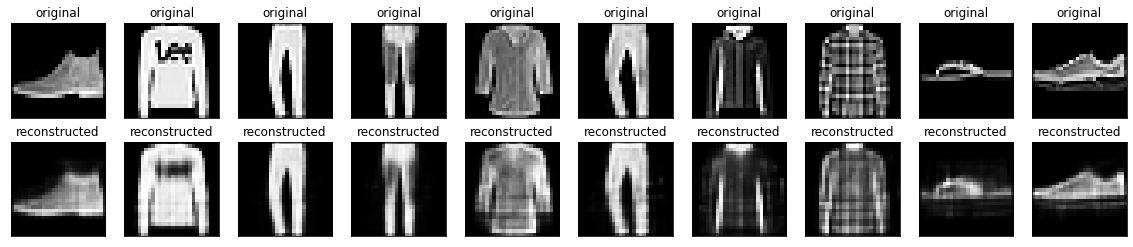

In [ ]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    # displaying original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_images[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Type II: Denoising Autoencoder

## Preprocessing data for convolution

In [ ]:
# reimporting to remove prior modifications
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_max=1.0, clip_value_min=0.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_max=1.0, clip_value_min=0.0)

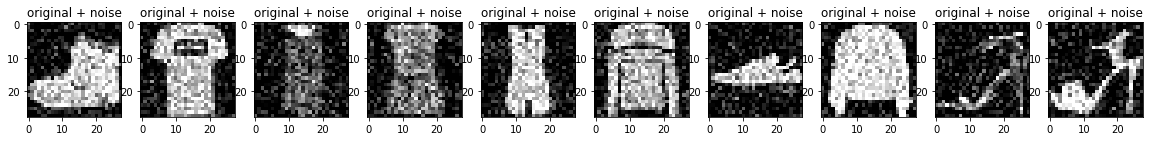

In [ ]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.title('original + noise')
    plt.imshow(tf.squeeze(X_train_noisy[i]))
    plt.gray()
plt.show()

## Defining Convolutional Autoencoder

In [ ]:
class Denoiser(Model):
    def __init__(self):
        super(Denoiser, self).__init__()
        self.encoder = tf.keras.Sequential([
                                            layers.Input(shape=(28,28,1)),
                                            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
                                            layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)
        ])
        self.decoder = tf.keras.Sequential([
                                            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                                            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                                            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Denoiser()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(X_train_noisy, X_train, epochs=10, shuffle=True, validation_data=(X_test_noisy, X_test))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0180 - val_loss: 0.0109
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.007

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


## Visualizing the results

In [ ]:
encoded_images = autoencoder.encoder(X_test).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

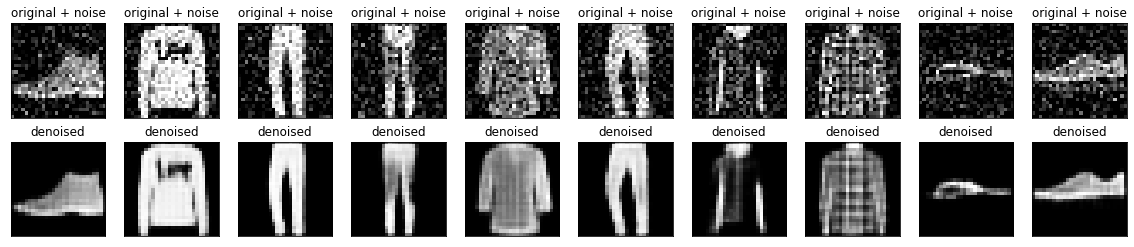

In [ ]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    # displaying original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.title('original + noise')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(tf.squeeze(decoded_images[i]))
    plt.title('denoised')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Type III: Anomaly Detection

## Processing the dataset

In [ ]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [ ]:
# the label is the last column
labels = raw_data[:, -1]
# the rest of the data are the points on the ECG
data = raw_data[:, 0:-1]

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2
)

In [ ]:
min_val = tf.reduce_max(X_train)
max_val = tf.reduce_min(X_train)

train_data = (X_train - min_val)/(max_val - min_val)
test_data = (X_test - min_val)/(max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# we will be training out autoencoder using only the normal rhythms, the anomalies will be the arhythmias

train_labels = y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

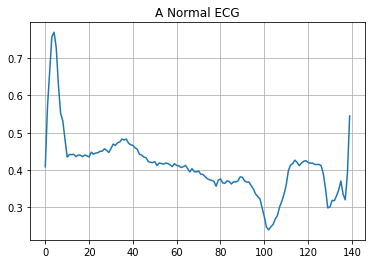

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

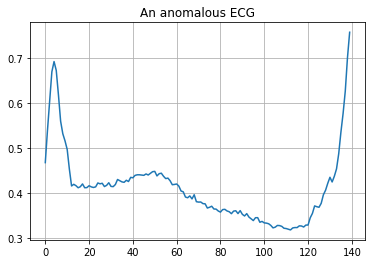

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('An anomalous ECG')
plt.show()

## Building the autoencoder class

In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
                                            layers.Dense(32, activation='relu'),
                                            layers.Dense(16, activation='relu'),
                                            layers.Dense(8, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
                                            layers.Dense(16, activation='relu'),
                                            layers.Dense(32, activation='relu'),
                                            layers.Dense(140, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(
    normal_train_data, normal_train_data, epochs=20,
    validation_data = (test_data, test_data), # notice how we are evaluating on the entire data
    shuffle = True
)


Epoch 1/20
73/73 [==============================] - 0s 5ms/step - loss: 0.0633 - val_loss: 0.0391
Epoch 2/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0237 - val_loss: 0.0381
Epoch 3/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0230 - val_loss: 0.0380
Epoch 4/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0225 - val_loss: 0.0362
Epoch 5/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.0339
Epoch 6/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.0331
Epoch 7/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0327
Epoch 8/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0324
Epoch 9/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0320
Epoch 10/20
73/73 [==============================] - 0s 4ms/step - loss: 0.0183 - val_loss: 0.0319
Epoch 11/20
73/73 [

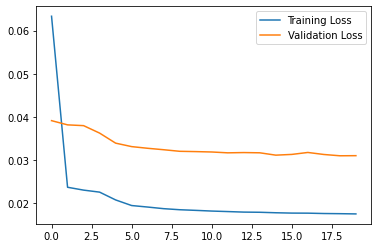

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

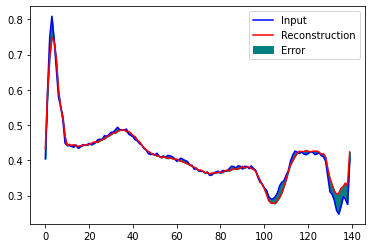

In [ ]:
encoded_images = autoencoder.encoder(normal_test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_images[0], 'r')
plt.fill_between(np.arange(140), decoded_images[0], normal_test_data[0], color='teal')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

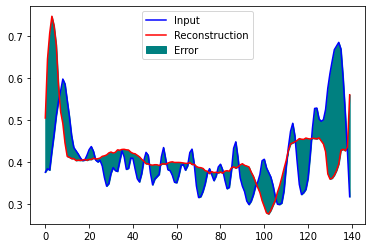

In [ ]:
encoded_img = autoencoder.encoder(anomalous_test_data).numpy()
decoded_img = autoencoder.decoder(encoded_img).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_img[0], 'r')
plt.fill_between(np.arange(140), decoded_img[0], anomalous_test_data[0], color='teal')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

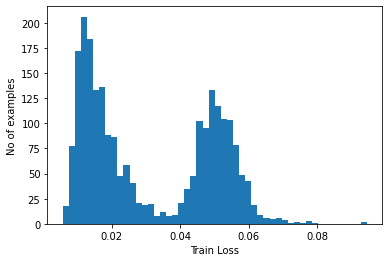

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel('Train Loss')
plt.ylabel('No of examples')
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print('Threshold: ', threshold)

Threshold:  0.04981555


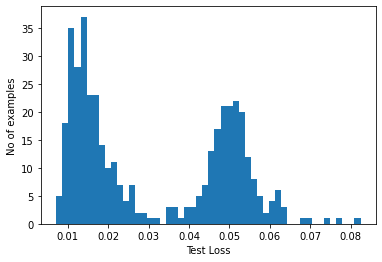

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel('Test Loss')
plt.ylabel('No of examples')
plt.show()

In [ ]:
def predict(model, data, threshold):
    reconstruction = model(data)
    loss = tf.keras.losses.mae(reconstruction, data)
    return tf.math.less(loss, threshold)

def print_stats(preds, labels):
    print('Accuracy: {}'.format(accuracy_score(labels, preds)))
    print('Precision: {}'.format(precision_score(labels, preds)))
    print('Recall: {}'.format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy: 0.564
Precision: 0.5987012987012987
Recall: 0.7840136054421769
